### A notebook to support academic question exploration and literature search / what do you do when you search the literature?

0. Define a research question e.g Is occupational **asbestos exposure** an underecognised **cause** of IPF? 
1. Consider the different possible ways of answering the question (methods). Different study designs and ways of measuring asbestos exposure e.g Epidemiological, observational, cross-sectional, cohort, case-control, post-mortem and explant studies, ecological, toxicology, animal models, molecular disease models, exposure assessment, occupational hygeinst measurements, minerologic analysis (tissue, BAL etc)
2. Generate search terms e.g "IPF", "case-control", "occupational", "asbestos" (? && mesh terms)
3. Carry out search using search terms and e.g pubmed, google scholar, scopus, biorxiv, web of science, clinicaltrials.gov, ?google books
4. Search results == Candidate Papers
5. Extract title | journal | author | location | year | abstract | key words | full text && save result (as .bib) (prob want to export to jabref)
6. Review Candidate Papers to identify Relevant Papers 
7. Use Relevant Papers to identify more Candidate papers. Search also by author, cited by, cite, [triangle closing](https://en.wikipedia.org/wiki/Triadic_closure) e.g https://github.com/hinnefe2/bibcheck.py and other means (?tensorflow)
8. Use the Relevant Papers collected for whatever it is they are relevant for (usually to help compose a written document in which they are cited)

meta: github/stack exchange etc to check out other peoples search strategies. this is likely to be formulated as a machine learning problem somewhere.

#### interesting related I found includes: https://www.projectcredo.com/, http://citationexplorer.hoppmann.me/, lict from a previous nhshackday, https://github.com/jvoytek/pubmedbrain/blob/f5170a2e3540e0c2aa665559c86048dfb1583f16/documents/Voytek-brainSCANrPreprint.pdf, https://github.com/graeham/hackathon/blob/master/paperGraph.py

### search github for relevant stuff with the following 'webbit' 
> https://github.com/search?l=Python&q=http%3A%2F%2Feutils.ncbi.nlm.nih.gov%2Fentrez%2Feutils%2Fesearch.fcgi++stars%3A%3E5&ref=advsearch&type=Code&utf8=%E2%9C%93

gists and interwebs inc stackoverflow also helpful

tempting to dive into django a la https://github.com/afouchet/OpenReview but probably not essential and now is not optimal timing

https://github.com/gui11aume looks well documented, poss useful template
https://github.com/swcarpentry/2013-08-23-harvard/blob/b2097bc20833e0a58b2e73eecd1227d61bd5a00a/lessons/misc-biopython/eutils.md looks like nice intro to biopython utils and https://gist.github.com/bonzanini/5a4c39e4c02502a8451d, https://gist.github.com/ehazlett/1104507, https://gist.github.com/vtrubets/ef1dabb397ea6a05ce5b4e767ed15af9 (for use of icite), https://gist.github.com/mcfrank/c1ec74df1427278cbe53, http://stackoverflow.com/questions/17409107/obtaining-data-from-pubmed-using-python, https://github.com/bwallace/abstrackr-web/tree/master/abstrackr

### let's tackle pubmed first

In [1]:
"""
Notebook to support academic question exploration and literature search.

Thanks to https://marcobonzanini.wordpress.com/2015/01/12/searching-pubmed-with-python/ and 
http://www.fredtrotter.com/2014/11/14/hacking-on-the-pubmed-api/

Pubmed advanced search is helpful for designing search/experimenting https://www.ncbi.nlm.nih.gov/pubmed/advanced

Docs for NCBI esearch:
https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ESearch
https://www.nlm.nih.gov/bsd/mms/medlineelements.html
"""


'\nNotebook to support academic question exploration and literature search.\n\nThanks to https://marcobonzanini.wordpress.com/2015/01/12/searching-pubmed-with-python/ and \nhttp://www.fredtrotter.com/2014/11/14/hacking-on-the-pubmed-api/\n\nPubmed advanced search is helpful for designing search/experimenting https://www.ncbi.nlm.nih.gov/pubmed/advanced\n\nDocs for NCBI esearch:\nhttps://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ESearch\nhttps://www.nlm.nih.gov/bsd/mms/medlineelements.html\n'

In [80]:
from Bio import Entrez
from Bio import Medline
from tqdm import tqdm
import json
import requests
import pandas as pd
import pickle 
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def get_chunked_pmids(term, chunksize=50):
    """
    Return a list of Pubmed ids from pubmed search in chunks
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    count_handle = Entrez.esearch(db="pubmed",
                                  term=term,
                                  retmode="xml",
                                  rettype="count")
    count_results = Entrez.read(count_handle)
    count = int(count_results["Count"])

    retmax_requests = list(range(chunksize, count, chunksize))
    retmax_requests.append(count - retmax_requests[len(retmax_requests) - 1])

    for i, retmax in enumerate(retmax_requests):
        pmid_handle = Entrez.esearch(db="pubmed",
                                     term=term,
                                     sort="relevance",
                                     retmode="xml",
                                     usehistory='y',
                                     retstart=retmax,
                                     retmax=chunksize)
        results = Entrez.read(pmid_handle)
        yield results["IdList"]

In [4]:
def get_pubmed_summaries(pubmed_id):
    """
    Use the Pubmed API to return the summary of a pubmed article
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    pubmed_id = ', '.join(map(str, pubmed_id))
    handle = Entrez.esummary(db='pubmed', 
                             id=pubmed_id, 
                             retmode='json', 
                             rettype='abstract')
    return json.loads(handle.read())['result']
  

In [5]:
def get_pubmed_keywords(pubmed_id):
    """
    Use the Pubmed API to return the medline record and extract the key words of a pubmed article.
    Return {pmid:[list of keywords]}.
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.efetch(db='pubmed',
                           id=pubmed_id,
                           rettype='medline',
                           retmode='text')
    records = Medline.parse(handle)
    kw = []
    keywords = {}

    for record in records:
        pmid = record.get('PMID','?')
        mh = record.get('MH','?')
        for w in mh: 
            if w not in kw:
                kw.append(w)
        kw.sort()
        keywords[pmid] = kw
    return keywords

In [6]:
def get_pubmed_abstracts(pubmed_id):
    """
    Use the Pubmed API to return the medline record and extract the abstract of a pubmed article.
    Return {pmid:abstract}.
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.efetch(db='pubmed',
                           id=pubmed_id,
                           rettype='medline',
                           retmode='text')
    records = Medline.parse(handle)
    abstracts = {}

    for record in records:
        pmid = record.get('PMID','?')
        ab = record.get('AB','?')
        abstracts[pmid] = ab
    return abstracts

In [7]:
def get_pubmed_pubtypes(pubmed_id):
    """
    Use the Pubmed API to return the medline record and extract the abstract of a pubmed article.
    Return {pmid:pubtype}.
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.efetch(db='pubmed',
                           id=pubmed_id,
                           rettype='medline',
                           retmode='text')
    records = Medline.parse(handle)
    pubtypes = {}

    for record in records:
        pmid = record.get('PMID','?')
        pt = record.get('PT','?')
        pubtypes[pmid] = pt
    return pubtypes

In [8]:
def get_citation_information(pubmed_id):
    """
    Use the special citation api to return relative citation ratios
    """
    pubmed_id = ','.join(pubmed_id)
    citation_search = 'https://icite.od.nih.gov/api/pubs?pmids={0}'.format(pubmed_id)
    response = requests.get(citation_search).content
    str_response = response.decode('utf-8')
    data = json.loads(str_response)['data']
    citations = {}
    for record in data:
        pmid = record.get('pmid')
        rcr = record.get('relative_citation_ratio')
        citations[pmid] = rcr
    return citations
        

In [9]:
def lit_search(term):
    """
    Search pubmed for a term and collect information about the results
    """
    pmid_blocks = get_chunked_pmids(term, chunksize=200)
    summaries = []
    pubtypes = []
    abstracts = []
    keywords = []
    rcrs = []
    litsearch_results = [summaries, pubtypes, abstracts, keywords, rcrs]
    for i, block in enumerate(pmid_blocks):
        summaries.append(get_pubmed_summaries(block))
        pubtypes.append(get_pubmed_pubtypes(block))
        abstracts.append(get_pubmed_abstracts(block))
        keywords.append(get_pubmed_keywords(block))
        rcrs.append(get_citation_information(block))
        print("Processed block {0}".format(i))
        if i > 1:
            break
    pickle.dump( litsearch_results, open( "litsearch_results_{0}.p".format(term), "wb" ) )
    return summaries, pubtypes, abstracts, keywords, rcrs
        

In [10]:
term = 'idiopathic pulmonary fibrosis'
summaries, pubtypes, abstracts, keywords, rcrs = lit_search(term)
litsearch_results = pickle.load(open("litsearch_results_{0}.p".format(term), "rb"))


Processed block 0
Processed block 1
Processed block 2


In [11]:
pmid_blocks = get_chunked_pmids(term, chunksize=200)
pmids = list(pmid_blocks)

d = {}

#for i, pmid in enumerate(pmids):
for i, summary in enumerate(summaries):
    d[i] = pd.DataFrame(pmids[i], columns=['pmid'])
    d[i]['title'] = d[i]['pmid'].map(lambda x: summaries[i].get(x)['title'])
    d[i]['firstauthor'] = d[i]['pmid'].map(lambda x: summaries[i].get(x)['sortfirstauthor'])
    d[i]['lastauthor'] = d[i]['pmid'].map(lambda x: summaries[i].get(x)['lastauthor'])
    d[i]['journal'] = d[i]['pmid'].map(lambda x: summaries[i].get(x)['source'])
    d[i]['pubdate'] = d[i]['pmid'].map(lambda x: summaries[i].get(x)['sortpubdate'])
    d[i]['pubtype'] = d[i]['pmid'].map(lambda x: pubtypes[i].get(x))
    d[i]['abstract'] = d[i]['pmid'].map(lambda x: abstracts[i].get(x))
    d[i]['keywords'] = d[i]['pmid'].map(lambda x: keywords[i].get(x))
    d[i]['rcr'] = d[i]['pmid'].astype(int).map(lambda x: rcrs[i].get(x))
            
df = pd.concat(d.values(), ignore_index=True)
pd.set_option('max_colwidth',300)
df.head()

,pmid,title,firstauthor,lastauthor,journal,pubdate,pubtype,abstract,keywords,rcr
0,21719092,Idiopathic pulmonary fibrosis.,King TE Jr,Selman M,Lancet,2011/12/03 00:00,"[Journal Article, Review]","Idiopathic pulmonary fibrosis is a devastating, age-related lung disease of unknown cause that has few treatment options. This disease was once thought to be a chronic inflammatory process, but current evidence indicates that the fibrotic response is driven by abnormally activated alveolar epith...","[*Aging, *Apoptosis, *Attitude to Health, *Blood Gas Analysis/methods, *Capnography, *Cell Aging, *Cell Differentiation/immunology, *Cell Transformation, Neoplastic, *Clinical Trials as Topic, *Communication, *Consensus, *Cooperative Behavior, *DNA Methylation, *DNA, Bacterial, *Disease Manageme...",21.568686
1,24582190,Frequency and implication of autoimmune serologies in idiopathic pulmonary fibrosis.,Moua T,Ryu JH,Mayo Clin Proc,2014/03/01 00:00,"[Evaluation Studies, Journal Article]",OBJECTIVE: To assess the frequency and clinical implications of positive autoimmune serologies in patients with biopsy-confirmed idiopathic pulmonary fibrosis (IPF). PATIENTS AND METHODS: We reviewed the records of patients at our institution with biopsy-confirmed usual interstitial pneumonia (U...,"[*Aging, *Apoptosis, *Attitude to Health, *Blood Gas Analysis/methods, *Capnography, *Cell Aging, *Cell Differentiation/immunology, *Cell Transformation, Neoplastic, *Clinical Trials as Topic, *Communication, *Consensus, *Cooperative Behavior, *DNA Methylation, *DNA, Bacterial, *Disease Manageme...",1.128043
2,24251797,Pulmonary vascular limitation to exercise and survival in idiopathic pulmonary fibrosis.,van der Plas MN,Bresser P,Respirology,2014/02/01 00:00,"[Journal Article, Research Support, Non-U.S. Gov't]","BACKGROUND AND OBJECTIVE: Pulmonary hypertension is frequently observed in advanced idiopathic pulmonary fibrosis (IPF) and is associated with poor prognosis. Cardiopulmonary exercise testing (CPET) can be used to detect less advanced pulmonary vascular impairment, and therefore may be of progno...","[*Aging, *Apoptosis, *Attitude to Health, *Blood Gas Analysis/methods, *Capnography, *Cell Aging, *Cell Differentiation/immunology, *Cell Transformation, Neoplastic, *Clinical Trials as Topic, *Communication, *Consensus, *Cooperative Behavior, *DNA Methylation, *DNA, Bacterial, *Disease Manageme...",1.293934
3,24140943,Pathogenesis pathways of idiopathic pulmonary fibrosis in bleomycin-induced lung injury model in mice.,Shi K,Zheng J,Respir Physiol Neurobiol,2014/01/01 00:00,"[Journal Article, Research Support, Non-U.S. Gov't]","Our objective was to investigate the pathogenesis pathways of idiopathic pulmonary fibrosis (IPF). Bleomycin (BLM) induced animal models of experimental lung fibrosis were used. CHIP assay was executed to find the link between Smad3 and IL-31, and the expressions of TGF-beta1, Smad3, IL-31 and S...","[*Aging, *Apoptosis, *Attitude to Health, *Blood Gas Analysis/methods, *Capnography, *Cell Aging, *Cell Differentiation/immunology, *Cell Transformation, Neoplastic, *Clinical Trials as Topic, *Communication, *Consensus, *Cooperative Behavior, *DNA Methylation, *DNA, Bacterial, *Disease Manageme...",1.480776
4,25202034,Recent evidence for pharmacological treatment of idiopathic pulmonary fibrosis.,Covvey JR,Mancl EE,Ann Pharmacother,2014/12/01 00:00,"[Journal Article, Review]",OBJECTIVE: To describe emerging evidence for the pharmacological treatment of idiopathic pulmonary fibrosis (IPF). DATA SOURCES: A search of PubMed (1966 to July 2014) was performed using the terms idiopathic pulmonary fibrosis and treatment. STUDY SELECTION AND DATA EXTRACTION: Review of articl...,"[*Aging, *Apoptosis, *Attitude to Health, *Blood Gas Analysis/methods, *Capnography, *Cell Aging, *Cell Differentiation/immunology, *Cell Transformation, Neoplastic, *Clinical Trials as Topic, *Communication, *Consensus, *Cooperative Behavior, *DNA Methylation, *DNA

In [33]:
df.sort_values(by='rcr', ascending=False).head()

,pmid,title,firstauthor,lastauthor,journal,pubdate,pubtype,abstract,keywords,rcr
264,21471066,An official ATS/ERS/JRS/ALAT statement: idiopathic pulmonary fibrosis: evidence-based guidelines for diagnosis and management.,Raghu G,Schünemann HJ,Am J Respir Crit Care Med,2011/03/15 00:00,"[Journal Article, Practice Guideline, Research Support, Non-U.S. Gov't]","This document is an international evidence-based guideline on the diagnosis and management of idiopathic pulmonary fibrosis, and is a collaborative effort of the American Thoracic Society, the European Respiratory Society, the Japanese Respiratory Society, and the Latin American Thoracic Associa...","[*Activities of Daily Living, *Airway Remodeling, *Anti-Inflammatory Agents, Non-Steroidal/administration & dosage/adverse effects, *Bronchoalveolar Lavage Fluid, *Cell Cycle, *Cell Differentiation/drug effects/genetics, *Cell Movement, *Decision Support Techniques, *Diagnostic Techniques, Respi...",102.409113
247,26177183,An Official ATS/ERS/JRS/ALAT Clinical Practice Guideline: Treatment of Idiopathic Pulmonary Fibrosis. An Update of the 2011 Clinical Practice Guideline.,Raghu G,Schünemann HJ,Am J Respir Crit Care Med,2015/07/15 00:00,"[Journal Article, Practice Guideline]","BACKGROUND: This document updates the American Thoracic Society/European Respiratory Society/Japanese Respiratory Society/Latin American Thoracic Association guideline on idiopathic pulmonary fibrosis treatment. METHODS: Systematic reviews and, when appropriate, meta-analyses were performed to s...","[*Activities of Daily Living, *Airway Remodeling, *Anti-Inflammatory Agents, Non-Steroidal/administration & dosage/adverse effects, *Bronchoalveolar Lavage Fluid, *Cell Cycle, *Cell Differentiation/drug effects/genetics, *Cell Movement, *Decision Support Techniques, *Diagnostic Techniques, Respi...",32.391134
56,21571362,Pirfenidone in patients with idiopathic pulmonary fibrosis (CAPACITY): two randomised trials.,Noble PW,du Bois RM,Lancet,2011/05/21 00:00,"[Comparative Study, Journal Article, Multicenter Study, Randomized Controlled Trial, Research Support, Non-U.S. Gov't]","BACKGROUND: Idiopathic pulmonary fibrosis is a progressive and fatal lung disease with inevitable loss of lung function. The CAPACITY programme (studies 004 and 006) was designed to confirm the results of a phase 2 study that suggested that pirfenidone, a novel antifibrotic and anti-inflammatory...","[*Aging, *Apoptosis, *Attitude to Health, *Blood Gas Analysis/methods, *Capnography, *Cell Aging, *Cell Differentiation/immunology, *Cell Transformation, Neoplastic, *Clinical Trials as Topic, *Communication, *Consensus, *Cooperative Behavior, *DNA Methylation, *DNA, Bacterial, *Disease Manageme...",26.685945
0,21719092,Idiopathic pulmonary fibrosis.,King TE Jr,Selman M,Lancet,2011/12/03 00:00,"[Journal Article, Review]","Idiopathic pulmonary fibrosis is a devastating, age-related lung disease of unknown cause that has few treatment options. This disease was once thought to be a chronic inflammatory process, but current evidence indicates that the fibrotic response is driven by abnormally activated alveolar epith...","[*Aging, *Apoptosis, *Attitude to Health, *Blood Gas Analysis/methods, *Capnography, *Cell Aging, *Cell Differentiation/immunology, *Cell Transformation, Neoplastic, *Clinical Trials as Topic, *Communication, *Consensus, *Cooperative Behavior, *DNA Methylation, *DNA, Bacterial, *Disease Manageme...",21.568686
105,21992121,Efficacy of a tyrosine kinase inhibitor in idiopathic pulmonary fibrosis.,Richeldi L,du Bois RM,N Engl J Med,2011/09/22 00:00,"[Clinical Trial, Phase II, Journal Article, Multicenter Study, Randomized Controlled Trial, Research Support, Non-U.S. Gov't]","BACKGROUND: Idiopathic pulmonary fibrosis is a progressive lung disease with a high mortality rate. Because the signaling pathways activated by several tyrosine kinase receptors have been shown to be involved in lung fibrosis, it has been suggested that the i

In [26]:
df.firstauthor.value_counts().head()

Cottin V      10
Richeldi L     8
Raghu G        7
Behr J         6
Yang IV        6
Name: firstauthor, dtype: int64

In [27]:
df.lastauthor.value_counts().head()

Collard HR    17
Kaminski N     9
Richeldi L     8
du Bois RM     8
Maher TM       7
Name: lastauthor, dtype: int64

In [34]:
df.journal.value_counts().head()

Eur Respir J                 36
Am J Respir Crit Care Med    33
Chest                        28
PLoS One                     27
BMC Pulm Med                 21
Name: journal, dtype: int64

In [42]:
df.pubtype.astype(str).value_counts()

['Journal Article', "Research Support, Non-U.S. Gov't"]                                                                                                          112
['Journal Article']                                                                                                                                              102
['Journal Article', 'Review']                                                                                                                                     68
['Journal Article', "Research Support, Non-U.S. Gov't", 'Review']                                                                                                 32
['Journal Article', 'Research Support, N.I.H., Extramural']                                                                                                       25
['Journal Article', 'Research Support, N.I.H., Extramural', "Research Support, Non-U.S. Gov't"]                                                                   24
['Comparat

In [56]:
df[df.abstract.str.contains('case-control')].head()

,pmid,title,firstauthor,lastauthor,journal,pubdate,pubtype,abstract,keywords,rcr
19,26401883,MMP-9 1562C&amp;gt;T Gene Polymorphism and Efficacy of Glucocorticoid Therapy in Idiopathic Pulmonary Fibrosis Patients.,Zhang HT,Zhang YM,Genet Test Mol Biomarkers,2015/11/01 00:00,[Journal Article],"OBJECTIVE: To investigate the relationship between matrix metalloproteinase 9 (MMP-9) gene polymorphism and the efficacy of glucocorticoid therapy in idiopathic pulmonary fibrosis (IPF) patients. METHODS: We conducted a case-control study. Between January 2013 and September 2014, 115 patients at...","[*Aging, *Apoptosis, *Attitude to Health, *Blood Gas Analysis/methods, *Capnography, *Cell Aging, *Cell Differentiation/immunology, *Cell Transformation, Neoplastic, *Clinical Trials as Topic, *Communication, *Consensus, *Cooperative Behavior, *DNA Methylation, *DNA, Bacterial, *Disease Manageme...",0.000000
27,25811599,Thyroid Disease Is Prevalent and Predicts Survival in Patients With Idiopathic Pulmonary Fibrosis.,Oldham JM,Noth I,Chest,2015/09/01 00:00,"[Journal Article, Research Support, Non-U.S. Gov't]","BACKGROUND: A significant minority of patients with idiopathic pulmonary fibrosis (IPF) display features of autoimmunity without meeting the criteria for overt connective tissue disease. A link between IPF and other immune-mediated processes, such as hypothyroidism (HT), has not been reported. I...","[*Aging, *Apoptosis, *Attitude to Health, *Blood Gas Analysis/methods, *Capnography, *Cell Aging, *Cell Differentiation/immunology, *Cell Transformation, Neoplastic, *Clinical Trials as Topic, *Communication, *Consensus, *Cooperative Behavior, *DNA Methylation, *DNA, Bacterial, *Disease Manageme...",1.300599
204,24417616,Long-term outcome and use of 6-minute walk test in West Highland White Terriers with idiopathic pulmonary fibrosis.,Lilja-Maula LI,Rajamäki MM,J Vet Intern Med,2014/01/01 00:00,"[Journal Article, Research Support, Non-U.S. Gov't]","BACKGROUND: Idiopathic pulmonary fibrosis (IPF) is an incurable interstitial lung disease occurring mainly in West Highland White Terriers (WHWTs). The effects of IPF on survival and on exercise tolerance in WHWTs are unknown. OBJECTIVES: To evaluate survival, prognostic factors, and exercise to...","[*Activities of Daily Living, *Airway Remodeling, *Anti-Inflammatory Agents, Non-Steroidal/administration & dosage/adverse effects, *Bronchoalveolar Lavage Fluid, *Cell Cycle, *Cell Differentiation/drug effects/genetics, *Cell Movement, *Decision Support Techniques, *Diagnostic Techniques, Respi...",1.017476
219,21917441,Familial pulmonary fibrosis is the strongest risk factor for idiopathic pulmonary fibrosis.,García-Sancho C,Selman M,Respir Med,2011/12/01 00:00,"[Journal Article, Research Support, Non-U.S. Gov't]","Idiopathic pulmonary fibrosis (IPF) is a lethal lung disorder of unknown etiology. The disease is likely the result of complex interactions between genetic and environmental factors. Evidence suggests that certain environmental factors, such as cigarette smoking and metal dust exposures, or como...","[*Activities of Daily Living, *Airway Remodeling, *Anti-Inflammatory Agents, Non-Steroidal/administration & dosage/adverse effects, *Bronchoalveolar Lavage Fluid, *Cell Cycle, *Cell Differentiation/drug effects/genetics, *Cell Movement, *Decision Support Techniques, *Diagnostic Techniques, Respi...",1.983337
255,22183478,Bronchoalveolar lavage pepsin in acute exacerbation of idiopathic pulmonary fibrosis.,Lee JS,Collard HR,Eur Respir J,2012/02/01 00:00,"[Journal Article, Research Support, N.I.H., Extramural]",Some patients with idiopathic pulmonary fibrosis experience acute exacerbations in their respiratory status leading to substantial morbidity and mortality. Occult aspiration of gastric contents has been proposed as one possible mechanism leading to these acute exacerbations. We sought to determi...,"[*Activities of Daily Living, *Airway Remodeling, *Anti-Inflammatory Agents, Non-Steroid

In [61]:
df.pubdate = pd.to_datetime(df.pubdate)


In [62]:
df.head()

,pmid,title,firstauthor,lastauthor,journal,pubdate,pubtype,abstract,keywords,rcr
0,21719092,Idiopathic pulmonary fibrosis.,King TE Jr,Selman M,Lancet,2011-12-03,"[Journal Article, Review]","Idiopathic pulmonary fibrosis is a devastating, age-related lung disease of unknown cause that has few treatment options. This disease was once thought to be a chronic inflammatory process, but current evidence indicates that the fibrotic response is driven by abnormally activated alveolar epith...","[*Aging, *Apoptosis, *Attitude to Health, *Blood Gas Analysis/methods, *Capnography, *Cell Aging, *Cell Differentiation/immunology, *Cell Transformation, Neoplastic, *Clinical Trials as Topic, *Communication, *Consensus, *Cooperative Behavior, *DNA Methylation, *DNA, Bacterial, *Disease Manageme...",21.568686
1,24582190,Frequency and implication of autoimmune serologies in idiopathic pulmonary fibrosis.,Moua T,Ryu JH,Mayo Clin Proc,2014-03-01,"[Evaluation Studies, Journal Article]",OBJECTIVE: To assess the frequency and clinical implications of positive autoimmune serologies in patients with biopsy-confirmed idiopathic pulmonary fibrosis (IPF). PATIENTS AND METHODS: We reviewed the records of patients at our institution with biopsy-confirmed usual interstitial pneumonia (U...,"[*Aging, *Apoptosis, *Attitude to Health, *Blood Gas Analysis/methods, *Capnography, *Cell Aging, *Cell Differentiation/immunology, *Cell Transformation, Neoplastic, *Clinical Trials as Topic, *Communication, *Consensus, *Cooperative Behavior, *DNA Methylation, *DNA, Bacterial, *Disease Manageme...",1.128043
2,24251797,Pulmonary vascular limitation to exercise and survival in idiopathic pulmonary fibrosis.,van der Plas MN,Bresser P,Respirology,2014-02-01,"[Journal Article, Research Support, Non-U.S. Gov't]","BACKGROUND AND OBJECTIVE: Pulmonary hypertension is frequently observed in advanced idiopathic pulmonary fibrosis (IPF) and is associated with poor prognosis. Cardiopulmonary exercise testing (CPET) can be used to detect less advanced pulmonary vascular impairment, and therefore may be of progno...","[*Aging, *Apoptosis, *Attitude to Health, *Blood Gas Analysis/methods, *Capnography, *Cell Aging, *Cell Differentiation/immunology, *Cell Transformation, Neoplastic, *Clinical Trials as Topic, *Communication, *Consensus, *Cooperative Behavior, *DNA Methylation, *DNA, Bacterial, *Disease Manageme...",1.293934
3,24140943,Pathogenesis pathways of idiopathic pulmonary fibrosis in bleomycin-induced lung injury model in mice.,Shi K,Zheng J,Respir Physiol Neurobiol,2014-01-01,"[Journal Article, Research Support, Non-U.S. Gov't]","Our objective was to investigate the pathogenesis pathways of idiopathic pulmonary fibrosis (IPF). Bleomycin (BLM) induced animal models of experimental lung fibrosis were used. CHIP assay was executed to find the link between Smad3 and IL-31, and the expressions of TGF-beta1, Smad3, IL-31 and S...","[*Aging, *Apoptosis, *Attitude to Health, *Blood Gas Analysis/methods, *Capnography, *Cell Aging, *Cell Differentiation/immunology, *Cell Transformation, Neoplastic, *Clinical Trials as Topic, *Communication, *Consensus, *Cooperative Behavior, *DNA Methylation, *DNA, Bacterial, *Disease Manageme...",1.480776
4,25202034,Recent evidence for pharmacological treatment of idiopathic pulmonary fibrosis.,Covvey JR,Mancl EE,Ann Pharmacother,2014-12-01,"[Journal Article, Review]",OBJECTIVE: To describe emerging evidence for the pharmacological treatment of idiopathic pulmonary fibrosis (IPF). DATA SOURCES: A search of PubMed (1966 to July 2014) was performed using the terms idiopathic pulmonary fibrosis and treatment. STUDY SELECTION AND DATA EXTRACTION: Review of articl...,"[*Aging, *Apoptosis, *Attitude to Health, *Blood Gas Analysis/methods, *Capnography, *Cell Aging, *Cell Differentiation/immunology, *Cell Transformation, Neoplastic, *Clinical Trials as Topic, *Communication, *Consensus, *Cooperative Behavior, *DNA Methylation, *DNA, Bacterial, *Disease Manageme

In [88]:
df.groupby(df.pubdate.map(lambda x: x.year)).pmid.count()

pubdate
2008      1
2009      5
2010     30
2011     48
2012     76
2013    121
2014    122
2015    146
2016     51
Name: pmid, dtype: int64

In [90]:
df.index = df.pubdate

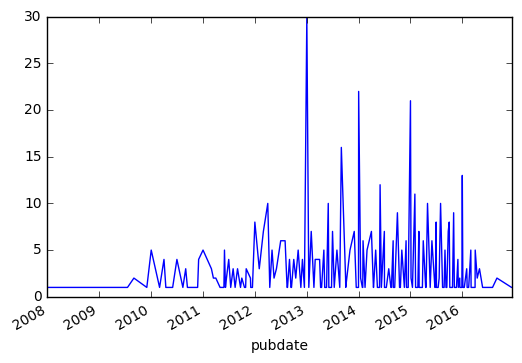

In [93]:
df.groupby('pubdate').pmid.count().plot()